In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline
import PIL
import math


In [2]:
tf. __version__

'2.0.0'

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 50 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [4]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])
    final_res = []
    for res in results:
        final_res.append(cv2.resize(res, (rows,col), interpolation = cv2.INTER_AREA))
    return final_res

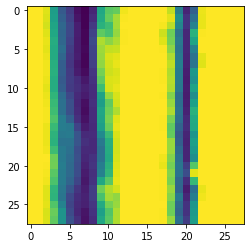

In [5]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
#pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/BuoniVal/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'


rows = 28
col = 28

pezziXimmagine = 20
border = 60
#Nclusters = 10

#results = []
img_train = []
img_test = []


list_paths = []



list_paths = glob.glob(pathBuoni)
list_paths += glob.glob(pathFS) 
#list_paths += glob.glob(pathScarti) 

count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    #try:
    img_train +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
    count += 1
    #except:
        #print('errore lettura')


list_paths = glob.glob(pathBuoniVal)
list_paths += glob.glob(pathFSVal) 
#list_paths += glob.glob(pathScartiVal) 

count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_test +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')



#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_test[10])
plt.show()

In [6]:

x_train = np.array(img_train)




x_train = x_train/255.
x_temp = np.empty((len(img_train), rows,col,1))
x_train = x_train.astype('float32')
for i in range(len(img_train)):
    x_temp[i]=(np.expand_dims(x_train[i], axis=2))
x_train = x_temp



x_temp = np.empty((len(img_train), rows,col,1))


x_temp = x_train.astype('float32')


x_test = np.array(img_test)
x_test = x_test/255.

x_temp = np.empty((len(img_test), rows,col,1))
for i in range(len(x_test)):
    x_temp[i]=(np.expand_dims(x_test[i], axis=2))
x_test = x_temp


x_train = x_train.astype('float32')

x_test = x_test.astype('float32')


In [7]:
x_test[0][0][0]

array([1.], dtype=float32)

In [8]:
x_train[0][0][0]

array([1.], dtype=float32)

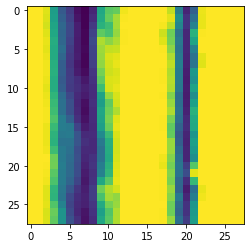

In [9]:
plt.imshow(x_test[10])
plt.show()

In [10]:
import keras.models
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Reshape, Flatten, Dense
from keras.layers import Conv2D, Cropping2D, Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.backend import int_shape


#pass the gray scale input image of size(28,28,1)
inputs = tf.keras.Input(shape=(rows,col, 1), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 1, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

Using TensorFlow backend.
2021-12-09 17:58:47.746534: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 17:58:47.746902: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [11]:
def SSIMLoss(y_true, y_pred):
    
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)

    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))




In [12]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)



In [13]:
autoencoder = tf.keras.Model(inputs, outputs)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [14]:
hist=autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                )


Train on 3440 samples, validate on 860 samples
Epoch 1/10
3440/3440 [==============================] - 19s 6ms/sample - loss: 0.2550 - val_loss: 0.8368
Epoch 2/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0435 - val_loss: 0.8105
Epoch 3/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0260 - val_loss: 0.8018
Epoch 4/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0201 - val_loss: 0.7749
Epoch 5/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0166 - val_loss: 0.7548
Epoch 6/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0145 - val_loss: 0.7172
Epoch 7/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0131 - val_loss: 0.6732
Epoch 8/10
3440/3440 [==============================] - 15s 4ms/sample - loss: 0.0119 - val_loss: 0.6309
Epoch 9/10
3440/3440 [==============================] - 14s 4ms/sample - loss: 0.0113 - val_loss: 0.5837
Epoch 10

In [ ]:
autoencoder.save('autoencoderNuovo2')

In [15]:
autoencoder_copy = autoencoder

In [16]:
autoencoder_copy = tf.keras.models.load_model('autoencoderNuovo2', compile=False)
autoencoder_copy.compile(optimizer=optimizer, loss=SSIMLoss)

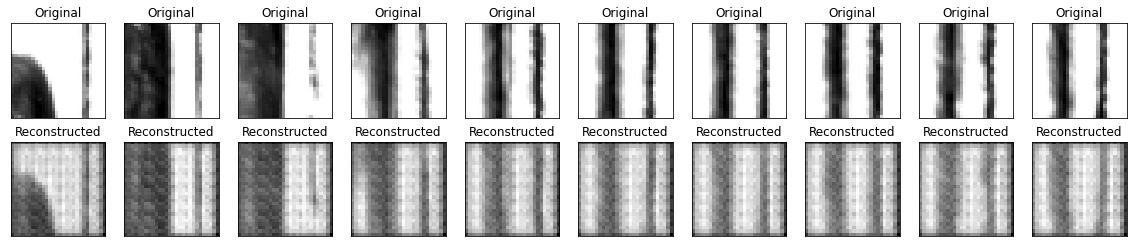

In [16]:
decoded_imgs = autoencoder_copy.predict(x_train)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(rows,col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(rows,col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
decoded_imgs = autoencoder_copy.predict(x_test)

In [18]:
values1 = []

for i in range(len(x_test)):
    print(str(i)+'/'+str(len(x_test)))


    value_a = SSIMLoss(x_test[i],decoded_imgs[i])
    values1.append(value_a.numpy())

0/860
1/860
2/860
3/860
4/860
5/860
6/860
7/860
8/860
9/860
10/860
11/860
12/860
13/860
14/860
15/860
16/860
17/860
18/860
19/860
20/860
21/860
22/860
23/860
24/860
25/860
26/860
27/860
28/860
29/860
30/860
31/860
32/860
33/860
34/860
35/860
36/860
37/860
38/860
39/860
40/860
41/860
42/860
43/860
44/860
45/860
46/860
47/860
48/860
49/860
50/860
51/860
52/860
53/860
54/860
55/860
56/860
57/860
58/860
59/860
60/860
61/860
62/860
63/860
64/860
65/860
66/860
67/860
68/860
69/860
70/860
71/860
72/860
73/860
74/860
75/860
76/860
77/860
78/860
79/860
80/860
81/860
82/860
83/860
84/860
85/860
86/860
87/860
88/860
89/860
90/860
91/860
92/860
93/860
94/860
95/860
96/860
97/860
98/860
99/860
100/860
101/860
102/860
103/860
104/860
105/860
106/860
107/860
108/860
109/860
110/860
111/860
112/860
113/860
114/860
115/860
116/860
117/860
118/860
119/860
120/860
121/860
122/860
123/860
124/860
125/860
126/860
127/860
128/860
129/860
130/860
131/860
132/860
133/860
134/860
135/860
136/860
137/860
138/86

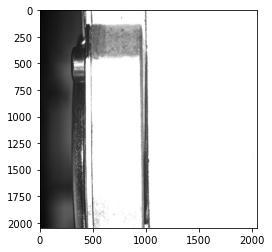

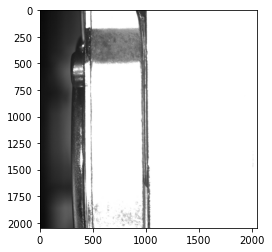

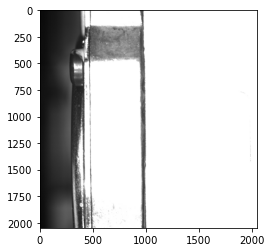

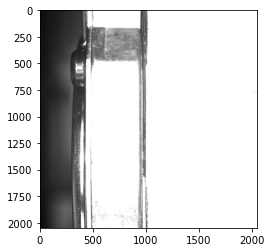

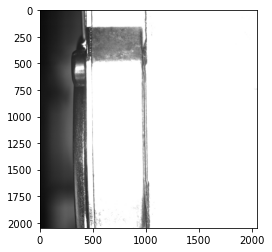

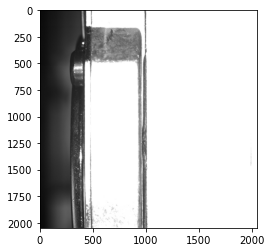

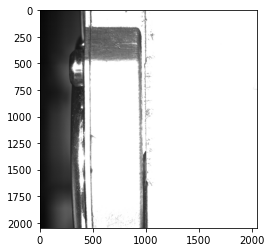

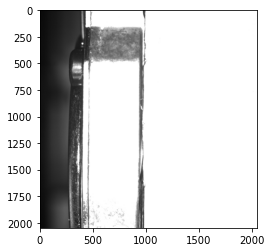

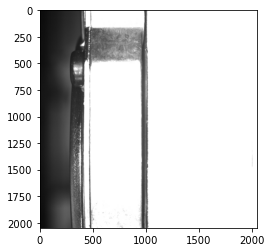

In [19]:
path = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#path = 'Desktop/Dataset/S606C/ScartiTotali/' 
border = 100
#Nclusters = 10

#results = []
imgs = []


list_paths = glob.glob(path) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        plt.imshow(img)
        plt.show()
        temp = cutWorkSpace(img,border)
        imgs +=  divideImage(temp,pezziXimmagine)
        #plt.imshow(temp)
        #plt.show()
        count += 1
    except:
        print('errore lettura')



        
x_test_final = np.array(imgs)
x_test_final = x_test_final/255.       


x_temp = np.empty((len(imgs), rows,col,1))

for i in range(len(imgs)):
    x_temp[i]=(np.expand_dims(x_test_final[i], axis=2))
x_test_final = x_temp


x_test_final = x_test_final.astype('float32')

In [20]:
decoded_imgs_final = autoencoder_copy.predict(x_test_final)

In [21]:
values2 = []

for i in range(len(x_test_final)):
    print(str(i)+ ' su '+ str(len(x_test_final)))
    value_a = SSIMLoss(x_test_final[i],decoded_imgs_final[i])
    values2.append(value_a.numpy())

0 su 180
1 su 180
2 su 180
3 su 180
4 su 180
5 su 180
6 su 180
7 su 180
8 su 180
9 su 180
10 su 180
11 su 180
12 su 180
13 su 180
14 su 180
15 su 180
16 su 180
17 su 180
18 su 180
19 su 180
20 su 180
21 su 180
22 su 180
23 su 180
24 su 180
25 su 180
26 su 180
27 su 180
28 su 180
29 su 180
30 su 180
31 su 180
32 su 180
33 su 180
34 su 180
35 su 180
36 su 180
37 su 180
38 su 180
39 su 180
40 su 180
41 su 180
42 su 180
43 su 180
44 su 180
45 su 180
46 su 180
47 su 180
48 su 180
49 su 180
50 su 180
51 su 180
52 su 180
53 su 180
54 su 180
55 su 180
56 su 180
57 su 180
58 su 180
59 su 180
60 su 180
61 su 180
62 su 180
63 su 180
64 su 180
65 su 180
66 su 180
67 su 180
68 su 180
69 su 180
70 su 180
71 su 180
72 su 180
73 su 180
74 su 180
75 su 180
76 su 180
77 su 180
78 su 180
79 su 180
80 su 180
81 su 180
82 su 180
83 su 180
84 su 180
85 su 180
86 su 180
87 su 180
88 su 180
89 su 180
90 su 180
91 su 180
92 su 180
93 su 180
94 su 180
95 su 180
96 su 180
97 su 180
98 su 180
99 su 180
100 su 180

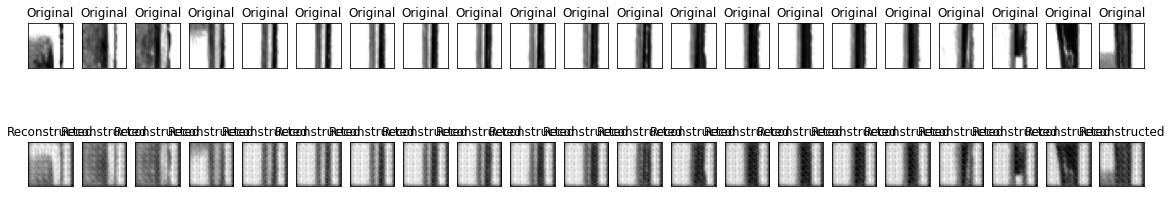

In [22]:
#decoded_imgs = autoencoder_copy.predict(x_test_final)
n = 21
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_final[i].reshape(rows, col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs_final[i].reshape(rows, col))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
values2

[0.31799126,
 0.51940787,
 0.5332547,
 0.54612744,
 0.5633409,
 0.52151895,
 0.51749647,
 0.5160434,
 0.51007485,
 0.5130229,
 0.50833607,
 0.50779617,
 0.5216235,
 0.5175545,
 0.52440304,
 0.5291574,
 0.52859294,
 0.53662527,
 0.54612374,
 0.54547274,
 0.6406157,
 0.59378934,
 0.5748239,
 0.53808165,
 0.58969814,
 0.5365033,
 0.5398584,
 0.5517087,
 0.5708881,
 0.5645592,
 0.57441723,
 0.5660898,
 0.56371176,
 0.56076604,
 0.57356083,
 0.55452967,
 0.54620636,
 0.5601299,
 0.5785247,
 0.5900532,
 0.43347687,
 0.506989,
 0.5058038,
 0.5276415,
 0.5408579,
 0.46585137,
 0.47019702,
 0.46576297,
 0.47497863,
 0.48293012,
 0.47343612,
 0.4841175,
 0.47586405,
 0.47044653,
 0.4670269,
 0.44872272,
 0.4613523,
 0.46817952,
 0.48256928,
 0.49543732,
 0.5657986,
 0.58308744,
 0.5757215,
 0.52229357,
 0.56293845,
 0.5105498,
 0.5091512,
 0.51479244,
 0.52017677,
 0.5203198,
 0.5197141,
 0.5154703,
 0.51281554,
 0.50571847,
 0.50744116,
 0.48616153,
 0.51727563,
 0.5491245,
 0.5514338,
 0.56716

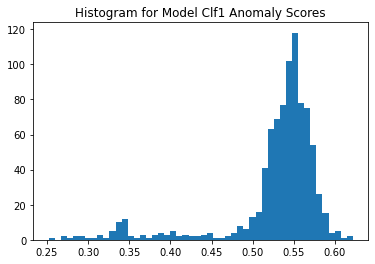

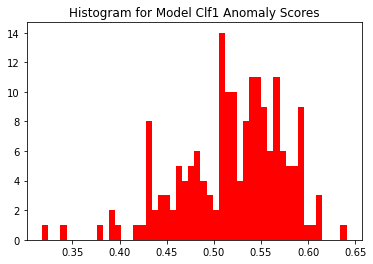

0.6406157


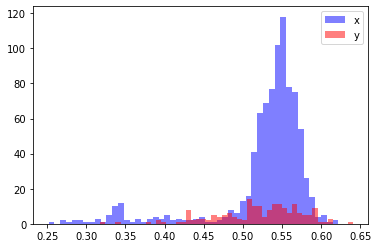

In [24]:
plt.hist(values1, bins=50)  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

#print(np.min(values1))

plt.hist(values2, bins=50, color='r')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

print(np.max(values2))

x = values1
y = values2


plt.hist(x, bins=50, alpha=0.5, label='x', color='b')
plt.hist(y, bins=50, alpha=0.5, label='y', color = 'r')
plt.legend(loc='upper right')
plt.show()



In [25]:

scoreSTX = values2
scoreSTY = []
for i in range(len(scoreSTX)):
    scoreSTY.append((i+1))
    
scoreX = values1
scoreY = []
for i in range(len(scoreX)):
    scoreY.append(i)




In [26]:
def maxFiveAvg(list_in):
    num = 5
    temp = np.copy(list_in)
    ordered = np.sort(temp)
    avg = 0.
    for i in range(num):
        avg += ordered[len(list_in)-1-i]
    avg = avg / num

    return avg
            

In [27]:
#pezziXimmagine

scoreSTX = []
scoreSTY = []
temp = 0
for i in range(int(len(values2)/pezziXimmagine)):
    scoreSTX.append(maxFiveAvg(values2[i*pezziXimmagine:(i*pezziXimmagine)+pezziXimmagine]))
    scoreSTY.append(i)
    
scoreX = []
scoreY = []
for i in range(int(len(values1)/pezziXimmagine)):
    scoreX.append(maxFiveAvg(values1[i*pezziXimmagine:(i*pezziXimmagine)+pezziXimmagine]))
    scoreY.append(i)




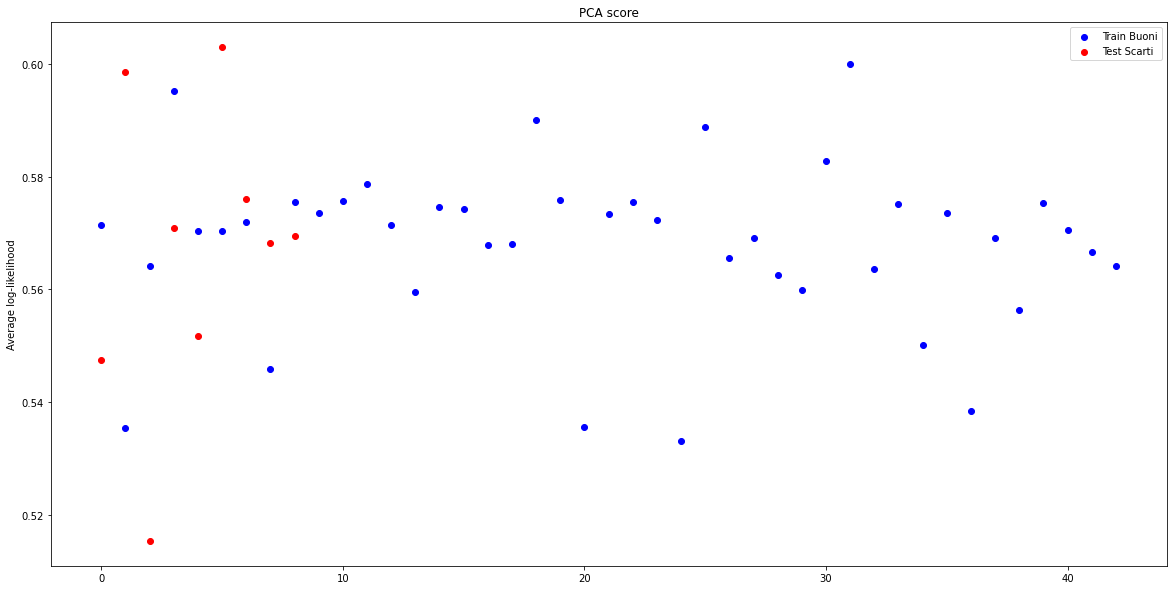

In [28]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
#plt.bar(scoreY,scoreX,label='Train Buoni',color='b',width=.5)
#plt.bar(scoreTOTY,scoreTOTX,label='Test Buoni',color='g',width=.5)
#plt.bar(scoreSTY,scoreSTX,label='Test Scarti',color='r',width=1.2)

plt.scatter(scoreY,scoreX,label='Train Buoni',color='b')
#plt.bar(scoreTOTY,scoreTOTX,label='Test Buoni',color='g',width=.5)
plt.scatter(scoreSTY,scoreSTX,label='Test Scarti',color='r')


#lim = -390
#x1 = [0, -600]
#y1 = [0, -600]
#plt.plot([-5,450],[lim,lim],label=('Limite identificazione scarto'))


#plt.bar([0.75,1.75,2.75,3.75,4.75],[50,30,20,50,60],

#label=”Female”, color=’g’,width=.5)

plt.legend()

#plt.xlabel('Days')

plt.ylabel('Average log-likelihood')
plt.title('PCA score')
plt.savefig('LogLik.png')
plt.show()




1


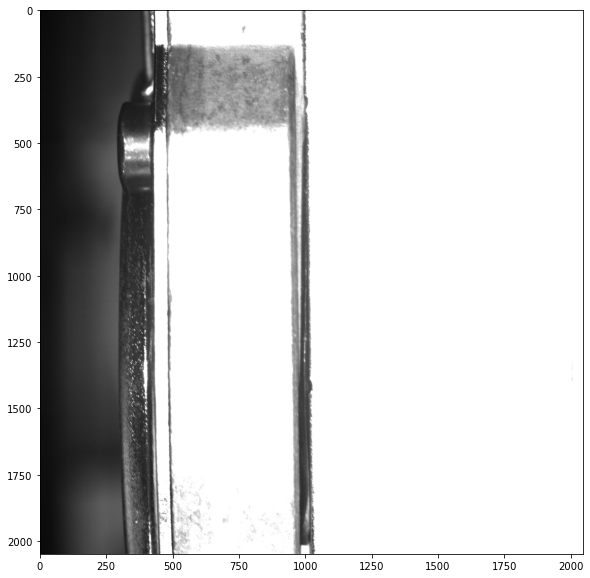

1 su 9
2


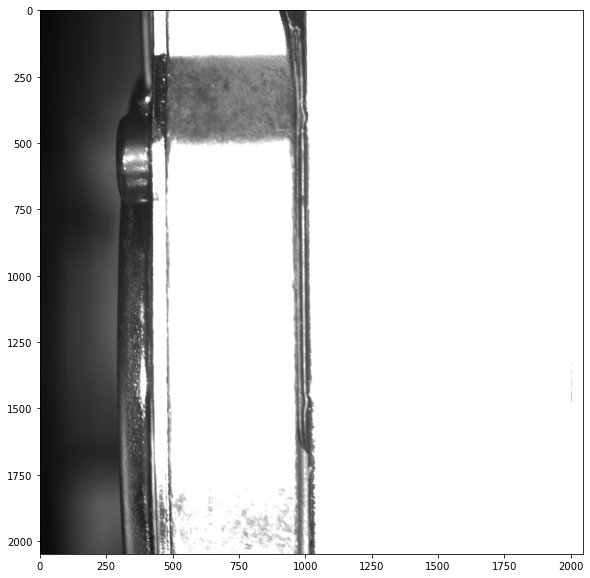

2 su 9
3


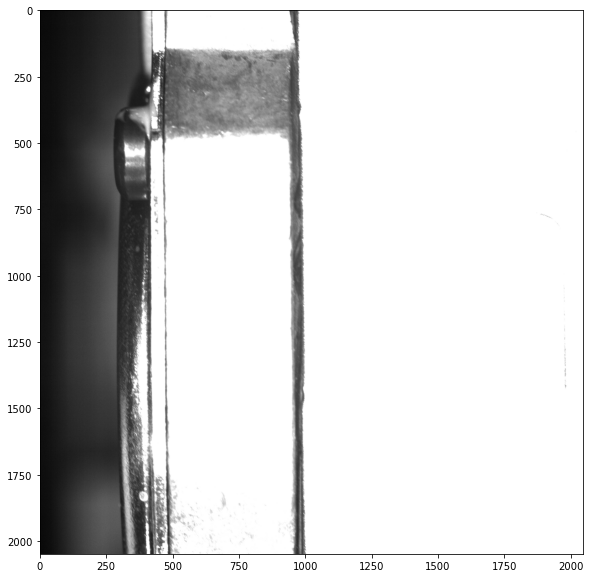

3 su 9
4


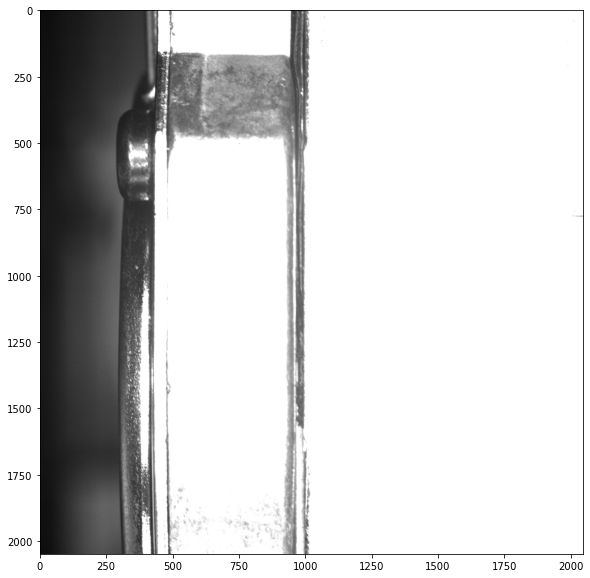

4 su 9
5


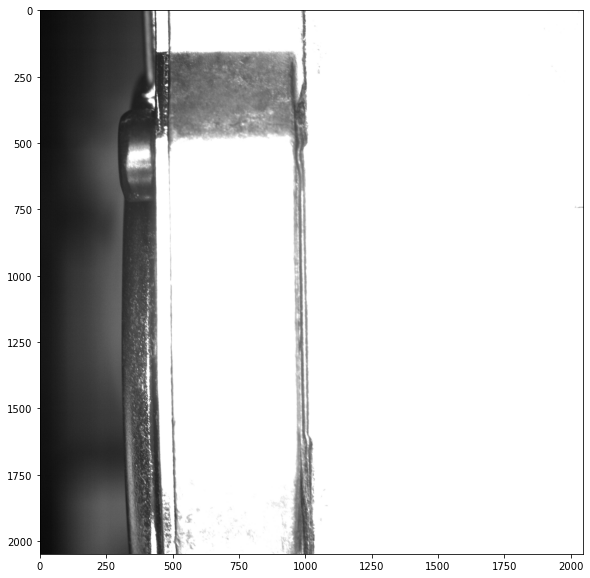

5 su 9
6


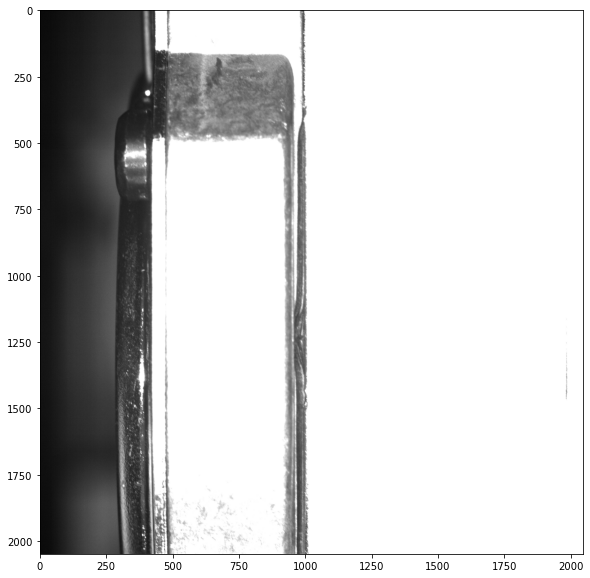

6 su 9
7


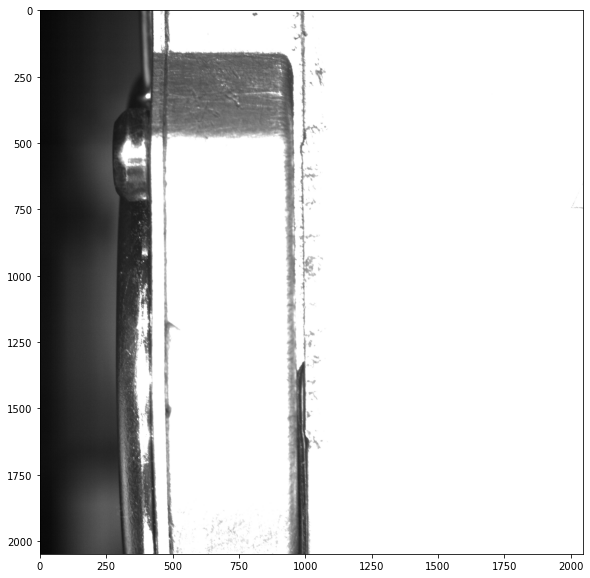

7 su 9
8


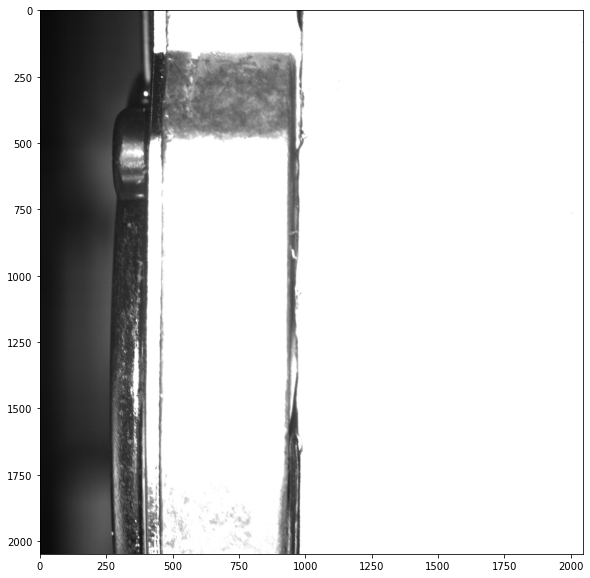

8 su 9
9


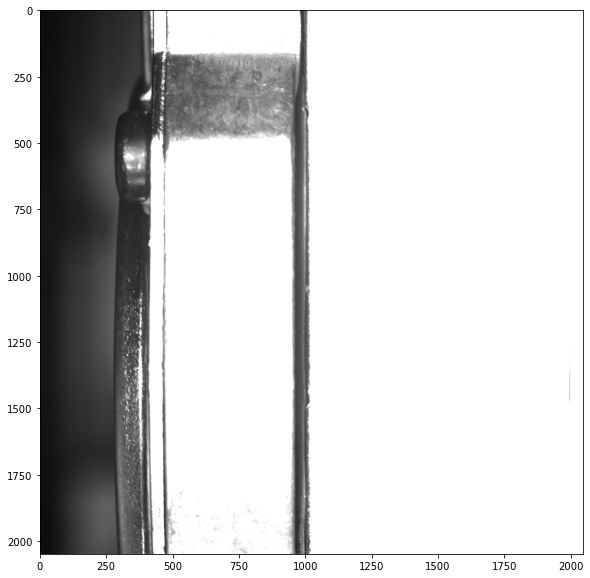

9 su 9


In [29]:
path = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

#path = '/Users/leonardoaggio/Desktop/Dataset/S606C/BuoniVal/*.tif'

#path = 'Desktop/Dataset/S606C/ScartiTotali/' 
border = 100
#Nclusters = 10

limite = 0.022

#results = []
imgs = []

errori = 0
list_paths = glob.glob(path) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
       # plt.imshow(img)
        #plt.show()
        temp = cutWorkSpace(img,border)
        imgs =  divideImage(temp,pezziXimmagine)
        #plt.imshow(temp)
        #plt.show()

        x_test_final = np.array(imgs)
        x_test_final = x_test_final/255.       


        x_temp = np.empty((len(imgs), rows,col,1))

        for i in range(len(imgs)):
            x_temp[i]=(np.expand_dims(x_test_final[i], axis=2))

        x_test_final = x_temp
        x_test_final = x_test_final.astype('float32')

        decoded_imgs_final = autoencoder_copy.predict(x_test_final)

        valuesTemp = []

        for i in range(len(x_test_final)):
            #print(str(i)+ ' su '+ str(len(x_test_final)))
            value_a = SSIMLoss(x_test_final[i],decoded_imgs_final[i])
            valuesTemp.append(value_a.numpy())

        scoreX = []
        scoreY = []
        i = 0
        scoreX.append(maxFiveAvg(valuesTemp[i*pezziXimmagine:(i*pezziXimmagine)+pezziXimmagine]))
        scoreY.append(i)

        count +=1
        print(count)
        
        
        
        if scoreX[0] > limite:
            plt.imshow(img)
            plt.show()
            errori += 1
            print(str(errori) + ' su '+ str(len(list_paths)))
        #if max(valuesTemp) > limite:
         #   plt.imshow(img)
          #  plt.show()
           # errori += 1
            #print(str(errori) + ' su '+ str(len(list_paths)))
    except:
        
        print('errore lettura')



